The dataset for this BINARY CLASSIFIER to be used is [bc-dataset.csv].
There are 2 implementations here:
1. Bag of words approach.
2. **Word vectors (can be pre-trained word embeddings).**

The dataset split is 60-40.
Evaluation metrics to be used in this are:
1. Precision.
2. Recall.
3. F-Measure.

Loads the dataset.

https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

In [27]:
from ftfy import fix_encoding
import pandas as pd
import numpy as np
import re
import csv
import string
import nltk as nlp
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

nlp.download("stopwords")
nlp.download('punkt')
nlp.download('wordnet')

#For GloVe
GLOVE_FILENAME = 'glove.42B.300d.txt'
STOP_WORDS = stopwords.words("english")

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def fix_encode(x):
    return fix_encoding(x)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(
    "datasets/bc-dataset.csv",
    encoding="latin1",
    sep=",",
    quoting=csv.QUOTE_ALL
)

data = pd.concat([df.gender, df['gender:confidence'], df.description], axis=1)

#drop null rows
print("Data Shape: " + str(data.shape))

Data Shape: (20050, 3)


In [29]:
data.dropna(subset=['description', 'gender'], inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender'] == 'brand'].index, inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender:confidence'] < 0.80].index, inplace=True)
data.drop('gender:confidence', axis=1, inplace=True)
data = data.reset_index(drop=True)

data.shape

(8847, 2)

In [30]:
data.description = data.description.apply(lambda x: fix_encode(x))

data['description']=data['description'].apply(lambda x : remove_URL(x))
data['description']=data['description'].apply(lambda x : remove_html(x))
data['description']=data['description'].apply(lambda x : remove_emoji(x))
data['description']=data['description'].apply(lambda x : remove_punct(x))
data.shape

(8847, 2)

In [32]:
print("ORIGINAL: ", data.description.iloc[999])

ORIGINAL:  The picture above is for reference purposes only


In [33]:
lemma = nlp.WordNetLemmatizer()
description_list = []

for each in data.description:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        # regex to clean unnecesarry chars
    each = each.lower()                                                              # lowercase all
    each = nlp.word_tokenize(each)                                                   # split all by tokenizing
    each = [word for word in each if not word in set(stopwords.words("english"))]    # delete stop words from your array
    each = [lemma.lemmatize(word) for word in each]                                  # lemmatize "memories" -> "memory"
    each = " ".join(each)                                                            # make them one string again
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    description_list.append(each)                                                         # put them into big array

# data['description'] = data['description'].apply(tweet_cleaning)

In [35]:
print("ORIGINAL: ", data.description.iloc[777])
print("PREPROCESSED: ", description_list[777])

ORIGINAL:  INFOart is all about tips advice and ideas for people who want to run their own business I also illustrate things  haydnsym  graphictide
PREPROCESSED:  infoart tip advice idea people want run business also illustrate thing haydnsym graphictide


In [36]:
data.gender = [0 if gender == 'female' else 1 for gender in data.gender]

data['gender'].value_counts(ascending=True)

1    4227
0    4620
Name: gender, dtype: int64

# MODEL BUILDING

In [37]:
from sklearn.model_selection import train_test_split

y = data.gender.values

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.4)

In [38]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

TOP_K = 20000 #number of features
MAX_SEQ_LEN = 50 #length of text sequences

class BC_Tokenizer():
    def __init__(self, train_text):
        self.train_text = train_text
        self.tokenizer = Tokenizer(num_words=TOP_K)
    
    def train_tokenize(self):
        max_len = len(max(self.train_text, key=len))
        self.max_len = min(max_len, MAX_SEQ_LEN)

        # vocabulary
        self.tokenizer.fit_on_texts(self.train_text)
    
    def vectorize_input(self, texts):
        #vectorize training
        texts = self.tokenizer.texts_to_sequences(texts)
        texts = sequence.pad_sequences(texts, maxlen=self.max_len, truncating='post', padding='post')
        return texts
    
tokenizer = BC_Tokenizer(train_text=X_train.description)

#fit
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['description'])
tokenized_test = tokenizer.vectorize_input(X_test['description'])

In [39]:
import tqdm

EMBEDDING_VECTOR_LENGTH = 50 #<=200

def construct_embedding_matrix(glove_file, word_index):
    embedding_dict={}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector #OOVs mapped to 0 vectors
    
    num_words = len(word_index)+1
    embedding_matrix = np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word, i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix

embedding_matrix = construct_embedding_matrix(GLOVE_FILENAME, tokenizer.tokenizer.word_index)

100%|██████████| 15834/15834 [00:00<00:00, 635016.92it/s]


In [40]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [41]:
print(embedding_matrix.shape[0])
print(len(tokenizer.tokenizer.word_index)+1)

15835
15835


In [42]:
from keras.layers import Embedding,LSTM,Dense,Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()

embedding = Embedding(len(tokenizer.tokenizer.word_index)+1,#unique tokens
                        EMBEDDING_VECTOR_LENGTH, #no. of features
                        embeddings_initializer=Constant(embedding_matrix), #initialize
                        input_length=MAX_SEQ_LEN,
                        trainable=False
                        )

model.add(embedding)
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

#compile
optimizer = Adam(clipvalue=0.5) #clip value to prevent the gradient exploding (?)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc', f1_m, precision_m,recall_m])

history = model.fit(tokenized_train, y_train, 
                    batch_size = 32,
                    epochs=10,
                    #validation_data=(tokenized_test,y_test),
                    validation_split=0.4,
                    verbose=2)


Epoch 1/10
100/100 - 13s - loss: 0.6911 - acc: 0.5214 - f1_m: 0.0761 - precision_m: 0.1996 - recall_m: 0.0605 - val_loss: 0.6728 - val_acc: 0.5857 - val_f1_m: 0.5486 - val_precision_m: 0.5533 - val_recall_m: 0.5552
Epoch 2/10
100/100 - 4s - loss: 0.6696 - acc: 0.5920 - f1_m: 0.4738 - precision_m: 0.6195 - recall_m: 0.4437 - val_loss: 0.6840 - val_acc: 0.5414 - val_f1_m: 0.0792 - val_precision_m: 0.4453 - val_recall_m: 0.0445
Epoch 3/10
100/100 - 5s - loss: 0.6660 - acc: 0.6008 - f1_m: 0.4441 - precision_m: 0.6371 - recall_m: 0.3802 - val_loss: 0.6691 - val_acc: 0.6224 - val_f1_m: 0.5825 - val_precision_m: 0.5985 - val_recall_m: 0.5822
Epoch 4/10
100/100 - 5s - loss: 0.6547 - acc: 0.6215 - f1_m: 0.5430 - precision_m: 0.6348 - recall_m: 0.5014 - val_loss: 0.6588 - val_acc: 0.6238 - val_f1_m: 0.4757 - val_precision_m: 0.6648 - val_recall_m: 0.3863
Epoch 5/10
100/100 - 5s - loss: 0.6537 - acc: 0.6269 - f1_m: 0.5130 - precision_m: 0.6708 - recall_m: 0.4425 - val_loss: 0.6512 - val_acc: 0.62

In [ ]:
print(model.summary())

In [43]:
loss, accuracy, f1_score, precision, recall = model.evaluate(tokenized_test, y_test, verbose=0)

In [44]:
print("Loss : ", loss)
print("Accuracy : ", accuracy)
print("F1 Score : ", f1_score)
print("Precision : ", precision)
print("Recall : ", recall)

# print(f'F1 Score: {"#.5f"%f1_score}')
# print(f'Precision: {"#.5f"%precision}')
# print(f'Recall: {"#.5f"%recall}')

Loss :  0.6527433395385742
Accuracy :  0.6326646208763123
F1 Score :  0.6230058670043945
Precision :  0.6202003359794617
Recall :  0.6428527235984802


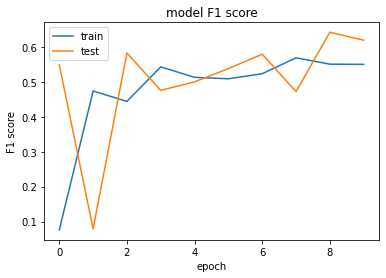

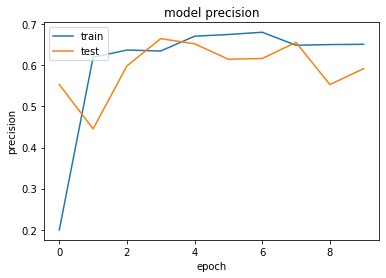

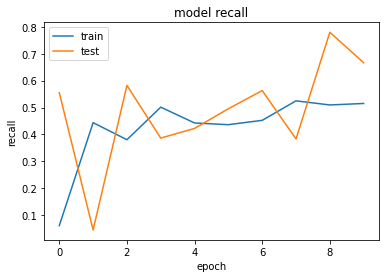

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
    
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()